<a href="https://colab.research.google.com/github/vferman2000/Springboard/blob/master/capstone2_lr_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fashion Image Classification Project

The objective of the project is to build a Convolutional Neural Network model to classify fashion product images using TensorFow and Keras functional API.  The model will then predict the class of a given input image.

The dataset can be downloaded from https://www.kaggle.com/paramaggarwal/fashion-product-images-dataset

The platform selected for the project is Google Collab.

This notebook contains the model with three different learning rates.




In [ ]:
# Install TensorFlow
import tensorflow as tf 
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
# importing additional libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import os

# Mounting to Google Drive

In [ ]:
# Path to fashion product images files on Google Drive

DATASET_PATH = "/content/drive/My Drive/Springboard Data Science/CapstoneTwo/fashion-product-images-small/myntradataset/"
print(os.listdir(DATASET_PATH))

['images', 'styles.csv']


In [ ]:
# Reading df_style pandas dataframe which contains images attributes

df_styles = pd.read_csv(DATASET_PATH + 'styles.csv', error_bad_lines=False)
df_styles['image'] = df_styles.apply(lambda row: str(row['id']) + ".jpg", axis=1)
#df_styles['image'] = df_styles.id.apply(lambda row: "%s.jpg" % row)

df_styles['masterCategory'] = df_styles.masterCategory.apply(lambda row: 'NA' if row is np.nan else row)

b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

There are 7 distinct product categories in the dataset.  As shown below, the categories are unevenly distributed.  The data will need to be stratified for balance.

In [ ]:
df_styles.masterCategory.value_counts()

Apparel           21397
Accessories       11274
Footwear           9219
Personal Care      2403
Free Items          105
Sporting Goods       25
Home                  1
Name: masterCategory, dtype: int64

In [ ]:
# There is only one sample in the Home category.  It will be omitted.
df_styles_labels = df_styles[df_styles.masterCategory != 'Home']

Splitting dataset into train, validation and test subsets where each subset is stratisfied by the values in the masterCategory column of df_styles dataframe


In [ ]:
def split_stratified_into_train_val_test(df_input, stratify_colname='y',
                                         frac_train=0.60, frac_val=0.20, frac_test=0.20,
                                         random_state=None):
    '''
    Splits a Pandas dataframe into three subsets (train, val, and test)
    following fractional ratios provided by the user, where each subset is
    stratified by the values in a specific column (that is, each subset has
    the same relative frequency of the values in the column). It performs this
    splitting by running train_test_split() twice.

    Parameters
    ----------
    df_input : Pandas dataframe
        Input dataframe to be split.
    stratify_colname : str
        The name of the column that will be used for stratification. Usually
        this column would be for the label.
    frac_train : float
    frac_val   : float
    frac_test  : float
        The ratios with which the dataframe will be split into train, val, and
        test data. The values should be expressed as float fractions and should
        sum to 1.0.
    random_state : int, None, or RandomStateInstance
        Value to be passed to train_test_split().

    Returns
    -------
    df_train, df_val, df_test :
        Dataframes containing the three splits.
    '''

    if frac_train + frac_val + frac_test != 1.0:
        raise ValueError('fractions %f, %f, %f do not add up to 1.0' % \
                         (frac_train, frac_val, frac_test))

    if stratify_colname not in df_styles.columns:
        raise ValueError('%s is not a column in the dataframe' % (stratify_colname))

    X = df_input # Contains all columns.
    y = df_input[[stratify_colname]] # Dataframe of just the column on which to stratify.

    # Split original dataframe into train and temp dataframes.
    df_train, df_temp, y_train, y_temp = train_test_split(X,
                                                          y,
                                                          stratify=y,
                                                          test_size=(1.0 - frac_train),
                                                          random_state=random_state)

    # Split the temp dataframe into val and test dataframes.
    relative_frac_test = frac_test / (frac_val + frac_test)
    df_validation, df_test, y_validation, y_test = train_test_split(df_temp,
                                                      y_temp,
                                                      stratify=y_temp,
                                                      test_size=relative_frac_test,
                                                      random_state=random_state)

    assert len(df_input) == len(df_train) + len(df_validation) + len(df_test)

    return df_train, df_validation, df_test

In [ ]:
df_train, df_validation, df_test = \
    split_stratified_into_train_val_test(df_styles_labels, stratify_colname='masterCategory', frac_train=0.60, frac_val=0.20, frac_test=0.20)

# Sampling structure
*   The train subset has 26653 samples.
*   The validation subset has 8885 samples.
*   The test subset has 8885 samples.


There are six unique categories in the masterCategory column that will be used as classes in the model.

In [ ]:
df_train.masterCategory.value_counts()

Apparel           12838
Accessories        6764
Footwear           5531
Personal Care      1442
Free Items           63
Sporting Goods       15
Name: masterCategory, dtype: int64

In [ ]:
# number of classes in masterCategory column of df_train
K = len(set(df_train.iloc[:,2]))
print('The number of classes is', K)

The number of classes is 6


In [ ]:
# Path to images folder
images_data = DATASET_PATH+"images/"

# Building the Convolutional Neural Network Model

The input image is 80x60 in size with a RGB channel. We will build a CNN model with a convolution + pooling architecture, followed by a number of fully connected Dense layers. 

The activation function for the convolutional layers will be ReLU ((Rectified Linear Units). 

The output layer will utilize a softmax activiation function for the multiclass classification.

The hyperparameters that will be used are:
MaxPooling2d(2, 2) which extracts certain features from the image and reduces its height and the width. By using 2 pooling layers, the height and width are 1/4 of the original sizes.

BatchNormalization which regularizes and makes the training of convolutional neural networks more efficient.

Dropout to avoid overfitting



In [ ]:
# Build the convolutional Neural Network model using the functional API

# Input node. image shape: 80 x 60 x 3 RGB channels
i= Input(shape=(80, 60, 3))


# 2D convolutional layer with 2 spatial dimensions (height and width)
# Using more filters results in a more powerful model, but we risk overfitting due to increased parameter count.
# 32 initial output feature maps that will progressively increase with network depth. (Starts low to check for overfitting)
# A 3D filter with 3x3x3 dimensions
# A ReLU activation funcion

x = Conv2D(32, (3, 3), activation='relu', padding='valid')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='valid')(x)
x = BatchNormalization()(x)

# Pooling layer to reduce dimensionality (max pooling takes the maximum value in the pooling window)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)

#Second convolutinal layer with increased number of feature maps
x = Conv2D(64, (3, 3), activation='relu', padding='valid')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='valid')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)

#Third convolutinal layer with increased number of feature maps
x = Conv2D(128, (3, 3), activation='relu', padding='valid')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='valid')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)

# Converting layer to 1 dimensional layer
x = Flatten()(x)
x = Dropout(0.2)(x)

# Fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)

# Fully connected layer with Softmax activation function for multiclass classification probability
x = Dense(K, activation='softmax')(x)

model = Model(i, x)

# Mapping images to MasterCategory classes in df_styles using ImageDataGenerator

In [ ]:
# Using ImageDataGenerator to correlate images from image folder to masterCategory column in df_train, df_validation an df_test 

from keras.preprocessing.image import ImageDataGenerator
HEIGHT = 80
WIDTH = 60
batch_size = 32
datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator=datagen.flow_from_dataframe(
                    dataframe=df_train,
                    directory=images_data,
                    x_col="image",
                    y_col="masterCategory",
                    batch_size=batch_size,
                    seed=42,
                    shuffle=True,
                    class_mode="categorical",
                    classes=['Footwear', 'Apparel', 'Accessories', 'Personal Care','Free Items','Sporting Goods'],
                    target_size=(HEIGHT,WIDTH))

valid_generator=test_datagen.flow_from_dataframe(
                    dataframe=df_validation,
                    directory=images_data,
                    x_col="image",
                    y_col="masterCategory",
                    batch_size=batch_size,
                    seed=42,
                    shuffle=True,
                    class_mode="categorical",
                    classes=['Footwear', 'Apparel', 'Accessories', 'Personal Care', 'Free Items','Sporting Goods'],
                    target_size=(HEIGHT,WIDTH))

test_generator=test_datagen.flow_from_dataframe(
                    dataframe=df_test,
                    directory=images_data,
                    x_col="image",
                    batch_size=1,
                    seed=42,
                    shuffle=False,
                    class_mode=None,
                    target_size=(HEIGHT,WIDTH))

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 9 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 26644 validated image filenames belonging to 6 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 8884 validated image filenames belonging to 6 classes.
Found 8883 validated image filenames.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 2 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


# Compiling and Fitting the Model

# Model # 1

*   Adam optimizer
*   Learning rate = 1e-4


In [ ]:
# Compiling the model
# lr = 0.0001
from tensorflow import keras

opt = keras.optimizers.Adam(lr=1e-4)

model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Fitting the model
model_output = model.fit(train_generator, validation_data=valid_generator, steps_per_epoch=int(train_generator.samples)/ batch_size, epochs=100)

Epoch 1/100
833/832 [==============================] - 15686s 19s/step - loss: 0.3482 - accuracy: 0.8930 - val_loss: 0.2008 - val_accuracy: 0.9370
Epoch 2/100
833/832 [==============================] - 152s 182ms/step - loss: 0.1566 - accuracy: 0.9512 - val_loss: 0.1018 - val_accuracy: 0.9678
Epoch 3/100
833/832 [==============================] - 150s 180ms/step - loss: 0.1118 - accuracy: 0.9657 - val_loss: 0.0923 - val_accuracy: 0.9722
Epoch 4/100
833/832 [==============================] - 151s 181ms/step - loss: 0.0903 - accuracy: 0.9738 - val_loss: 0.0786 - val_accuracy: 0.9766
Epoch 5/100
833/832 [==============================] - 150s 180ms/step - loss: 0.0764 - accuracy: 0.9781 - val_loss: 0.1090 - val_accuracy: 0.9690
Epoch 6/100
833/832 [==============================] - 151s 181ms/step - loss: 0.0664 - accuracy: 0.9809 - val_loss: 0.0770 - val_accuracy: 0.9750
Epoch 7/100
833/832 [==============================] - 150s 180ms/step - loss: 0.0517 - accuracy: 0.9852 - val_loss: 0

In [ ]:
# saving the model
model.save('/content/drive/My Drive/Springboard Data Science/CapstoneTwo/7model.h5')
model.save('/content/drive/My Drive/Springboard Data Science/CapstoneTwo/7model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/Springboard Data Science/CapstoneTwo/7model/assets


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 60, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 78, 58, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 78, 58, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 76, 56, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 76, 56, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 38, 28, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 38, 28, 32)        0     

# Testing the Model

In [ ]:
test_generator.reset()

In [ ]:
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
pred=model.predict(test_generator,verbose=1,steps=test_steps_per_epoch)

8883/8883 [==============================] - 3666s 413ms/step


In [ ]:
predicted_class_indices=np.argmax(pred,axis=1)

# Mapping the predicted labels with their unique id's

In [ ]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

# Constructing dataframe with predicted and true label comparision

In [ ]:
filenames=test_generator.filenames
results=pd.DataFrame({"image":filenames,
                      "predictions":predictions})

In [ ]:
true_and_predicted_labels = pd.merge(df_test[['id','image','masterCategory']], results, on="image")
true_and_predicted_labels.head()
x = true_and_predicted_labels['masterCategory'].unique()
print(x)

['Accessories' 'Apparel' 'Footwear' 'Personal Care' 'Free Items'
 'Sporting Goods']


In [ ]:
true_and_predicted_labels['correct_label'] = np.where(true_and_predicted_labels.masterCategory == true_and_predicted_labels.predictions, 1, 0)
true_and_predicted_labels.head()


,id,image,masterCategory,predictions,correct_label
0,37686,37686.jpg,Accessories,Accessories,1
1,52384,52384.jpg,Apparel,Apparel,1
2,31645,31645.jpg,Apparel,Apparel,1
3,35700,35700.jpg,Footwear,Footwear,1
4,16106,16106.jpg,Accessories,Accessories,1


In [ ]:
print('Test prediction accuracy:', true_and_predicted_labels['correct_label'].sum()/len(true_and_predicted_labels.predictions)*100)

Test prediction accuracy: 98.79545198694134


In [ ]:
score = model.evaluate(valid_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

278/278 [==============================] - 41s 146ms/step - loss: 0.1013 - accuracy: 0.9878
Test loss: 0.10134057700634003
Test accuracy: 0.9878433346748352


# Model Evaluation

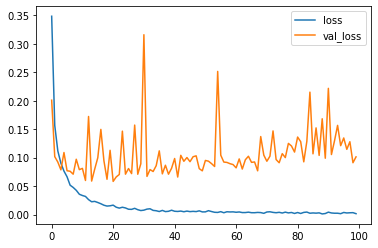

In [ ]:
# Plot loss per iteration
plt.plot(model_output.history['loss'], label='loss')
plt.plot(model_output.history['val_loss'], label='val_loss')
plt.legend()

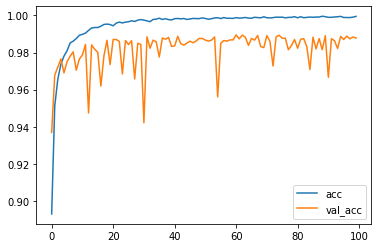

In [ ]:
# Plot accuracy per iteration
plt.plot(model_output.history['accuracy'], label='acc')
plt.plot(model_output.history['val_accuracy'], label='val_acc')
plt.legend()

# Confusion Matrix

In [ ]:
#Confusion Matrix and Classification Report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# valid_steps_per_epoch = np.math.ceil(valid_generator.samples / valid_generator.batch_size)
# valid_pred=model.predict(valid_generator,verbose=1,steps=valid_steps_per_epoch)
# predicted_valid_classes=np.argmax(valid_pred,axis=1)

# true_classes = valid_generator.classes
# class_labels = ['Personal Care','Apparel','Accessories', 'Footwear', 'Free Items']

# report = metrics.classification_report(true_classes, predicted_valid_classes, target_names=class_labels)
# print(report)   

valid_generator.reset()
test_steps_per_epoch = np.math.ceil(valid_generator.samples / valid_generator.batch_size)
Y_pred=model.predict(valid_generator,verbose=1,steps=test_steps_per_epoch)

classes = valid_generator.classes
y_pred = np.argmax(Y_pred, axis=-1)
sum(y_pred==classes)/10000

confusion_matrix(valid_generator.classes,y_pred)

278/278 [==============================] - 40s 143ms/step


array([[ 575, 1129,  443,    7,   99,    2],
       [1114, 1993,  935,    6,  230,    1],
       [ 448,  917,  370,    0,  109,    0],
       [   7,    8,    5,    0,    1,    0],
       [ 129,  237,   92,    0,   22,    0],
       [   1,    1,    1,    0,    2,    0]])

In [ ]:
labels_x = (valid_generator.class_indices)
labels_x = dict((v,k) for k,v in labels_x.items())
predictions_x = [labels[k] for k in y_pred]

filenames_x=valid_generator.filenames
results_x=pd.DataFrame({"image":filenames_x,
                      "predictions":predictions_x})

true_and_predicted_labels_x = pd.merge(df_test[['image','masterCategory']], results, on="image")
true_and_predicted_labels_x.head()
xy = true_and_predicted_labels['predictions'].unique()
print(xy)

['Accessories' 'Apparel' 'Footwear' 'Personal Care' 'Free Items'
 'Sporting Goods']


278/278 [==============================] - 40s 143ms/step
Confusion matrix, without normalization
[[ 574 1088  454    5  131    3]
 [1100 2062  904    4  209    0]
 [ 474  891  383    2   94    0]
 [   6    8    4    0    3    0]
 [ 118  234  101    2   25    0]
 [   2    2    0    0    1    0]]


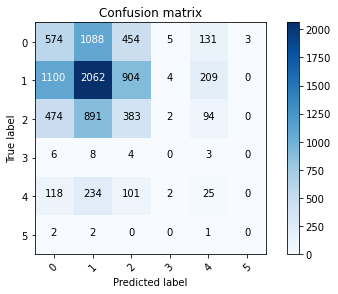

In [ ]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

valid_generator.reset()
valid_steps_per_epoch = np.math.ceil(valid_generator.samples / valid_generator.batch_size)
p_test=model.predict(valid_generator,verbose=1,steps=valid_steps_per_epoch).argmax(axis=1)

cm = confusion_matrix(valid_generator.classes, p_test)
plot_confusion_matrix(cm, list(range(6)))




# Model # 2

*   Adam optimizer
*   Learning rate = 1e-2

In [ ]:
# Build the convolutional Neural Network model using the functional API

# Input node. image shape: 80 x 60 x 3 RGB channels
i= Input(shape=(80, 60, 3))


# 2D convolutional layer with 2 spatial dimensions (height and width)
# Using more filters results in a more powerful model, but we risk overfitting due to increased parameter count.
# 32 initial output feature maps that will progressively increase with network depth. (Starts low to check for overfitting)
# A 3D filter with 3x3x3 dimensions
# A ReLU activation funcion

x = Conv2D(32, (3, 3), activation='relu', padding='valid')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='valid')(x)
x = BatchNormalization()(x)

# Pooling layer to reduce dimensionality (max pooling takes the maximum value in the pooling window)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)

#Second convolutinal layer with increased number of feature maps
x = Conv2D(64, (3, 3), activation='relu', padding='valid')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='valid')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)

#Third convolutinal layer with increased number of feature maps
x = Conv2D(128, (3, 3), activation='relu', padding='valid')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='valid')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)

# Converting layer to 1 dimensional layer
x = Flatten()(x)
x = Dropout(0.2)(x)

# Fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)

# Fully connected layer with Softmax activation function for multiclass classification probability
x = Dense(K, activation='softmax')(x)

model_2 = Model(i, x)

In [ ]:
# Compiling the model
# lr = 0.01

opt_2 = keras.optimizers.Adam(lr=1e-2)

model_2.compile(optimizer=opt_2,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Fitting the model
model_output_2 = model_2.fit(train_generator, validation_data=valid_generator, steps_per_epoch=int(train_generator.samples)/ batch_size, epochs=100)

Epoch 1/100
833/832 [==============================] - 162s 195ms/step - loss: 1.0860 - accuracy: 0.8728 - val_loss: 0.3714 - val_accuracy: 0.8569
Epoch 2/100
833/832 [==============================] - 161s 194ms/step - loss: 0.2653 - accuracy: 0.9207 - val_loss: 0.6321 - val_accuracy: 0.7799
Epoch 3/100
833/832 [==============================] - 162s 194ms/step - loss: 0.2091 - accuracy: 0.9402 - val_loss: 0.2587 - val_accuracy: 0.9209
Epoch 4/100
833/832 [==============================] - 160s 192ms/step - loss: 0.1772 - accuracy: 0.9495 - val_loss: 0.5225 - val_accuracy: 0.8867
Epoch 5/100
833/832 [==============================] - 160s 192ms/step - loss: 0.1831 - accuracy: 0.9487 - val_loss: 1.8898 - val_accuracy: 0.6266
Epoch 6/100
833/832 [==============================] - 159s 191ms/step - loss: 0.1904 - accuracy: 0.9481 - val_loss: 0.2364 - val_accuracy: 0.9591
Epoch 7/100
833/832 [==============================] - 161s 193ms/step - loss: 0.1804 - accuracy: 0.9544 - val_loss: 0

In [ ]:
# saving the model
model_2.save('/content/drive/My Drive/Springboard Data Science/CapstoneTwo/8model.h5')
model_2.save('/content/drive/My Drive/Springboard Data Science/CapstoneTwo/8model')

INFO:tensorflow:Assets written to: /content/drive/My Drive/Springboard Data Science/CapstoneTwo/8model/assets


In [ ]:
score_2 = model_2.evaluate(valid_generator)
print('Test loss:', score_2[0])
print('Test accuracy:', score_2[1])

278/278 [==============================] - 39s 142ms/step - loss: 0.4559 - accuracy: 0.9053
Test loss: 0.10134057700634003
Test accuracy: 0.9878433346748352


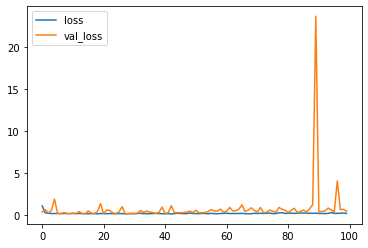

In [ ]:
# Plot loss per iteration
plt.plot(model_output_2.history['loss'], label='loss')
plt.plot(model_output_2.history['val_loss'], label='val_loss')
plt.legend()

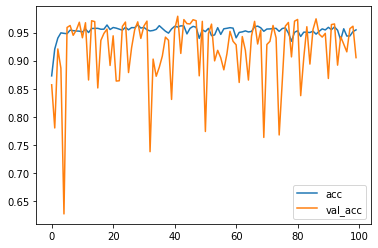

In [ ]:
# Plot accuracy per iteration
plt.plot(model_output_2.history['accuracy'], label='acc')
plt.plot(model_output_2.history['val_accuracy'], label='val_acc')
plt.legend()

278/278 [==============================] - 39s 140ms/step
Confusion matrix, without normalization
[[ 783  910  447    0  115    0]
 [1456 1765  862    0  196    0]
 [ 645  747  373    0   79    0]
 [  12    7    2    0    0    0]
 [ 174  185   96    0   25    0]
 [   3    1    0    0    1    0]]


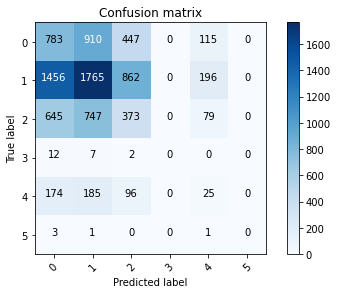

In [ ]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

valid_generator.reset()
valid_steps_per_epoch = np.math.ceil(valid_generator.samples / valid_generator.batch_size)
test_2=model_2.predict(valid_generator,verbose=1,steps=valid_steps_per_epoch).argmax(axis=1)

cm = confusion_matrix(valid_generator.classes, test_2)
plot_confusion_matrix(cm, list(range(6)))

# Model # 3

*   Adam optimizer
*   Learning rate = 1e-1

In [ ]:
# Build the convolutional Neural Network model using the functional API

# Input node. image shape: 80 x 60 x 3 RGB channels
i= Input(shape=(80, 60, 3))


# 2D convolutional layer with 2 spatial dimensions (height and width)
# Using more filters results in a more powerful model, but we risk overfitting due to increased parameter count.
# 32 initial output feature maps that will progressively increase with network depth. (Starts low to check for overfitting)
# A 3D filter with 3x3x3 dimensions
# A ReLU activation funcion

x = Conv2D(32, (3, 3), activation='relu', padding='valid')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='valid')(x)
x = BatchNormalization()(x)

# Pooling layer to reduce dimensionality (max pooling takes the maximum value in the pooling window)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)

#Second convolutinal layer with increased number of feature maps
x = Conv2D(64, (3, 3), activation='relu', padding='valid')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='valid')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)

#Third convolutinal layer with increased number of feature maps
x = Conv2D(128, (3, 3), activation='relu', padding='valid')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='valid')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)

# Converting layer to 1 dimensional layer
x = Flatten()(x)
x = Dropout(0.2)(x)

# Fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)

# Fully connected layer with Softmax activation function for multiclass classification probability
x = Dense(K, activation='softmax')(x)

model_3 = Model(i, x)

In [ ]:
# Compiling the model
# lr = 0.1

opt_3 = keras.optimizers.Adam(lr=1e-1)

model_3.compile(optimizer=opt_3,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Fitting the model
model_output_3 = model_3.fit(train_generator, validation_data=valid_generator, steps_per_epoch=int(train_generator.samples)/ batch_size, epochs=100)

Epoch 1/100
833/832 [==============================] - 158s 190ms/step - loss: 13.1948 - accuracy: 0.5034 - val_loss: 1.2048 - val_accuracy: 0.4817
Epoch 2/100
833/832 [==============================] - 158s 190ms/step - loss: 1.2107 - accuracy: 0.4805 - val_loss: 1.2029 - val_accuracy: 0.4817
Epoch 3/100
833/832 [==============================] - 159s 190ms/step - loss: 1.2097 - accuracy: 0.4816 - val_loss: 1.2142 - val_accuracy: 0.4817
Epoch 4/100
833/832 [==============================] - 158s 190ms/step - loss: 1.2111 - accuracy: 0.4816 - val_loss: 1.2201 - val_accuracy: 0.4817
Epoch 5/100
833/832 [==============================] - 159s 191ms/step - loss: 1.2086 - accuracy: 0.4816 - val_loss: 1.2115 - val_accuracy: 0.4817
Epoch 6/100
833/832 [==============================] - 158s 190ms/step - loss: 1.2096 - accuracy: 0.4816 - val_loss: 1.2308 - val_accuracy: 0.4817
Epoch 7/100
833/832 [==============================] - 159s 191ms/step - loss: 1.2095 - accuracy: 0.4816 - val_loss: 